In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe

import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration

from spike_statistics.core import permutation_resampling

10:56:10 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
plt.rcParams['figure.dpi'] = 150
plt.rc('axes', titlesize=12)

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "comparisons-gridcells"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [5]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(sessions, statistics_results, on='action')
statistics.head()

,action,control,entity,frequency,session,stim_location,stimulated,tag,channel_group,unit_name,...,interspike_interval_cv,burst_event_ratio,bursty_spike_ratio,gridness,border_score,information_rate,head_mean_ang,head_mean_vec_len,spacing,orientation
0,1849-060319-3,True,1849,NaN,3,NaN,False,baseline ii,1,104,...,3.970863,0.397921,0.676486,-0.459487,0.078474,0.965845,5.788704,0.043321,0.624971,22.067900
1,1849-060319-3,True,1849,NaN,3,NaN,False,baseline ii,1,108,...,1.219777,0.146481,0.277121,-0.615405,0.311180,0.191375,1.821598,0.014624,0.753333,0.000000
2,1849-060319-3,True,1849,NaN,3,NaN,False,baseline ii,1,85,...,5.470099,0.373466,0.658748,-0.527711,0.131660,3.833587,4.407614,0.121115,0.542877,27.758541
3,1849-060319-3,True,1849,NaN,3,NaN,False,baseline ii,1,94,...,1.652501,0.097464,0.196189,-0.641543,0.274989,0.153740,6.128601,0.099223,0.484916,11.309932
4,1849-060319-3,True,1849,NaN,3,NaN,False,baseline ii,1,98,...,1.425851,0.248036,0.461250,-0.085292,0.198676,0.526720,1.602362,0.051825,0.646571,0.000000


# slice unique units

In [6]:
# statistics = statistics.drop_duplicates('unit_id')
# statistics.head()

In [7]:
print('N cells:',statistics.shape[0])

N cells: 840


In [8]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('shuffling') / "statistics" / "cell_quantiles_95.csv")
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel,unit
0,0.350476,0.046932,5.989893,0.069916,0.055549,0.075058,1346-030813-01,6,0
1,0.318905,0.180482,4.898164,0.052385,0.096919,0.005426,1346-030813-01,6,1
2,0.308449,0.228607,5.937449,0.200862,0.037687,0.018586,1346-030813-01,6,2
3,0.348864,0.103796,6.144787,0.040004,0.146299,0.111281,1346-050813-01,7,0
4,0.384443,0.163223,5.995363,0.192211,0.249075,0.107522,1346-130713-01,2,0


In [9]:
action_columns = ['action', 'channel', 'unit']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,tag,familiar,i,ii,iii,chabc,pre,day1,day2,...,head_mean_vec_len,spacing,orientation,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1346-030813-01,AMK control familiar,True,True,False,False,False,True,False,False,...,0.097494,0.549496,0.000000,0.350476,0.046932,5.989893,0.069916,0.055549,0.075058,0.202142
1,1346-030813-01,AMK control familiar,True,True,False,False,False,True,False,False,...,0.017567,0.575214,29.248826,0.318905,0.180482,4.898164,0.052385,0.096919,0.005426,0.162962
2,1346-030813-01,AMK control familiar,True,True,False,False,False,True,False,False,...,0.120361,0.401846,17.818889,0.308449,0.228607,5.937449,0.200862,0.037687,0.018586,0.663900
3,1346-050813-01,AMK control familiar,True,True,False,False,False,True,False,False,...,0.069026,0.590583,24.145542,0.348864,0.103796,6.144787,0.040004,0.146299,0.111281,0.099337
4,1346-130713-01,AMK control familiar,True,True,False,False,False,True,False,False,...,0.184529,0.457893,7.125016,0.384443,0.163223,5.995363,0.192211,0.249075,0.107522,0.743949


# Statistics about all cell-sessions

In [10]:
data.groupby('chabc').count()['action']

chabc
False    373
True     467
Name: action, dtype: int64

# Find all cells with gridness above threshold

In [11]:
query = 'gridness > gridness_threshold and information_rate > information_rate_threshold'
sessions_above_threshold = data.query(query)
print("Number of gridcell sessions", len(sessions_above_threshold))

Number of gridcell sessions 152


In [12]:
print("Number of gridcells", len(sessions_above_threshold.groupby(['animal', 'channel', 'unit'])))
print("Number of animals", len(sessions_above_threshold.groupby(['animal'])))
familiar_i = sessions_above_threshold.query('familiar and i')
print("Number of gridcells in familiar i sessions", len(familiar_i))
print("Number of gridcells in familiar i chabc vs control", len(familiar_i.query('chabc')), len(familiar_i.query('not chabc')))

Number of gridcells 99
Number of animals 13
Number of gridcells in familiar i sessions 147
Number of gridcells in familiar i chabc vs control 61 86


# Calculate statistics

In [13]:
columns = ['average_rate', 'gridness',
           'max_rate', 'information_rate', 'interspike_interval_cv', 
           'in_field_mean_rate', 'out_field_mean_rate', 
           'burst_event_ratio', 'specificity']

In [14]:
familiar = sessions_above_threshold.query('familiar')
familiar.to_csv(output_path / "gridcells_in_familiar.csv", index=True)
print(len(familiar))
familiar.groupby('chabc')[columns].mean()

149


,average_rate,gridness,max_rate,information_rate,interspike_interval_cv,in_field_mean_rate,out_field_mean_rate,burst_event_ratio,specificity
chabc,,,,,,,,,
False,1.975043,0.619279,11.291841,0.527476,2.024646,3.798279,1.096465,0.093356,0.573435
True,1.909061,0.604262,8.331724,0.290853,1.622192,3.118775,1.280178,0.041739,0.451446


In [15]:
familiar.query('not chabc')[columns].describe()

,average_rate,gridness,max_rate,information_rate,interspike_interval_cv,in_field_mean_rate,out_field_mean_rate,burst_event_ratio,specificity
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,1.975043,0.619279,11.291841,0.527476,2.024646,3.798279,1.096465,0.093356,0.573435
std,1.631465,0.279160,7.036430,0.498433,0.565255,2.683254,1.092063,0.073813,0.164642
min,0.245794,0.088243,1.670813,0.048416,1.052848,0.615108,0.128427,0.005780,0.240397
25%,1.036994,0.384231,6.033217,0.203035,1.620444,2.016805,0.506159,0.037906,0.464598
50%,1.533070,0.633878,9.320878,0.363700,1.843574,2.945330,0.851226,0.075827,0.574536
75%,2.268654,0.860993,15.843196,0.691066,2.347461,4.639685,1.161764,0.132937,0.674205
max,8.479849,1.135609,31.559843,2.806037,4.009179,13.380700,5.891095,0.412335,0.961474


In [16]:
familiar.query("chabc")[columns].describe()

,average_rate,gridness,max_rate,information_rate,interspike_interval_cv,in_field_mean_rate,out_field_mean_rate,burst_event_ratio,specificity
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1.909061,0.604262,8.331724,0.290853,1.622192,3.118775,1.280178,0.041739,0.451446
std,1.377641,0.244313,5.675225,0.273220,0.422667,1.939850,1.172417,0.049640,0.177476
min,0.254788,0.136885,1.690662,0.043085,1.079223,0.624683,0.080813,0.000000,0.110626
25%,0.860899,0.390572,4.651358,0.120465,1.299363,1.560754,0.516622,0.009543,0.327504
50%,1.665746,0.561777,6.929151,0.197723,1.534315,2.847462,0.950270,0.020661,0.445086
75%,2.343518,0.814328,10.064717,0.381816,1.804559,3.933533,1.613243,0.061049,0.562175
max,6.491272,1.108716,33.780838,1.844484,3.069920,8.913977,5.608727,0.221226,0.888179


# Create nice table

In [20]:
def summarize(data):
    return "{:.2f} ± {:.2f} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))

chabc_names = {False: 'Control', 
               True: 'chABC'}

result = pd.DataFrame()

result['Control'] = familiar.query('not chabc')[columns].agg(summarize)
result['chABC'] = familiar.query('chabc')[columns].agg(summarize)
# result = familiar.groupby('chabc', as_index=False)[columns].agg(summarize)
# result['chabc'] = result['chabc'].map(chabc_names)
# result = result.set_index('chabc')
# result.index.name = None
# result = result.T

# def WRS(column):
#     '''
#     Wilcoxon Rang Sum
#     '''
#     Zvalue, pvalue = scipy.stats.ranksums(
#         familiar.query('not chabc')[column], familiar.query('chabc')[column])
#     if pvalue < 0.0001:
#         return "WRS Z = {:.2f}, p < 0.001".format(Zvalue)
#     return "WRS Z = {:.2f}, p = {:.3f}".format(Zvalue, pvalue)


def MWU(column):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        familiar.query('not chabc')[column].dropna(), 
        familiar.query('chabc')[column].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(column):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        familiar.query('not chabc')[column].dropna(), 
        familiar.query('chabc')[column].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()
result.index = map(rename, result.index)

result['MWU'] = list(map(MWU, columns))
# result['WRS'] = list(map(WRS, columns))
result['PRS'] = list(map(PRS, columns))


result.to_latex(output_path / "statistics" / "statistics.tex")
result.to_latex(output_path / "statistics" / "statistics.csv")
result

,Control,chABC,MWU,PRS
Average rate,1.98 ± 0.18 (86),1.91 ± 0.17 (63),"2695.00, 0.959","0.13, 0.627"
Gridness,0.62 ± 0.03 (86),0.60 ± 0.03 (63),"2812.00, 0.694","0.07, 0.370"
Max rate,11.29 ± 0.76 (86),8.33 ± 0.72 (63),"3385.00, 0.009","2.39, 0.011"
Information rate,0.53 ± 0.05 (86),0.29 ± 0.03 (63),"3688.00, 0.000","0.17, 0.004"
Interspike interval cv,2.02 ± 0.06 (86),1.62 ± 0.05 (63),"3975.00, 0.000","0.31, 0.000"
In-field mean rate,3.80 ± 0.29 (86),3.12 ± 0.24 (63),"3059.00, 0.179","0.10, 0.495"
Out-field mean rate,1.10 ± 0.12 (86),1.28 ± 0.15 (63),"2395.00, 0.228","0.10, 0.200"
Burst event ratio,0.09 ± 0.01 (86),0.04 ± 0.01 (63),"4148.50, 0.000","0.06, 0.000"
Specificity,0.57 ± 0.02 (86),0.45 ± 0.02 (63),"3796.00, 0.000","0.13, 0.000"


# Violinplot

In [23]:
def violinplot(control, chabc):
    Uvalue, pvalue = scipy.stats.mannwhitneyu(control, chabc, alternative='two-sided')
    print("U-test", Uvalue, pvalue)

    pos = [0.0, 0.7]

    violins = plt.violinplot([control, chabc], pos, showmedians=True, showextrema=False)

#     for i, body in enumerate(violins['bodies']):
#         body.set_color('C{}'.format(i))
#         body.set_linewidth(2)#         body.set_linewidth(2)
    violins['bodies'][0].set_color ('#2166ac')
    violins['bodies'][1].set_color ('#b2182b')
    violins['bodies'][0].set_color ('#053061')
    violins['bodies'][1].set_color ('#67001f')
    violins['bodies'][0].set_color ('#4393c3')
    violins['bodies'][1].set_color ('#d6604d')
    violins['bodies'][0].set_alpha (0.8)
    violins['bodies'][1].set_alpha (0.8)

    # for i, body in enumerate(violins['cbars']):
    #     body.set_color('C{}'.format(i))

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['k', 'k'])
            violins[category].set_linewidth(2.0)

    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    plt.xticks(pos, ["Control", "chABC"])

    x1, x2 = pos
    data_max = np.max([control.max(), chabc.max()])
    data_min = np.min([control.min(), chabc.min()])
    y = data_max * 1.08
    h = 0.025 * (data_max - data_min)
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')

# Information rate

U-test 3688.0 0.00016992230582916584


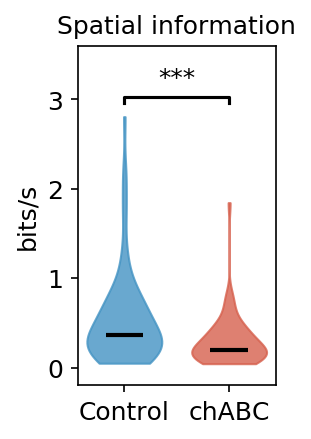

In [29]:
control = familiar.query('not chabc and information_rate < 6')['information_rate'].to_numpy()
chabc = familiar.query('chabc and information_rate < 6')['information_rate'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Spatial information")
#plt.ylabel("(bits/s)",labelpad=10)
plt.ylabel("bits/s")
plt.ylim(-0.2, 3.6)
#plt.xlim(-0.4, 1.1)
#plt.rc('xtick', labelsize=13) 
#plt.rc('ytick', labelsize=11)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "spatial_information.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "spatial_information.png", dpi=600, bbox_inches="tight")

U-test 3796.0 2.9800185913914725e-05


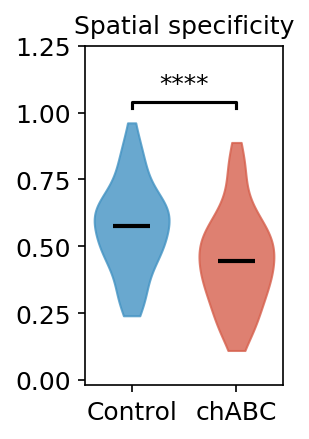

In [30]:
control = familiar.query('not chabc')['specificity'].to_numpy()
chabc = familiar.query('chabc')['specificity'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Spatial specificity")
#plt.ylabel("(bits/s)",labelpad=10)
plt.ylabel("")
plt.ylim(-0.02, 1.25)
#plt.xlim(-0.4, 1.1)
#plt.rc('xtick', labelsize=11) 
#plt.rc('ytick', labelsize=11)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "specificity.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "specificity.png", dpi=600, bbox_inches="tight")

U-test 2695.0 0.9586281849215867


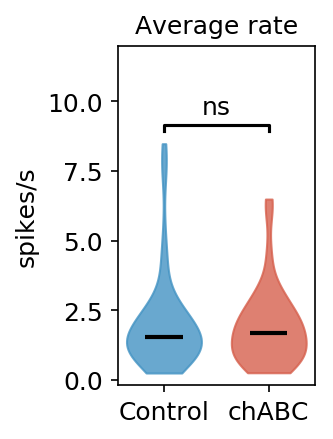

In [31]:
control = familiar.query('not chabc and average_rate < 10')['average_rate'].to_numpy()
chabc = familiar.query('chabc and average_rate < 10')['average_rate'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Average rate")
plt.ylabel("spikes/s")
plt.ylim(-0.2, 12)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "average_rate.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "average_rate.png", dpi=600, bbox_inches="tight")

U-test 3385.0 0.009440444055083515


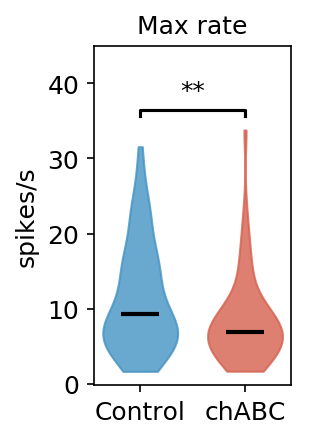

In [32]:
control = familiar.query('not chabc and average_rate < 10')['max_rate'].to_numpy()
chabc = familiar.query('chabc and average_rate < 10')['max_rate'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Max rate")
plt.ylabel("spikes/s")
plt.ylim(-0.2, 45)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "max_rate.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "max_rate.png", dpi=600, bbox_inches="tight")

U-test 3975.0 1.1572868879606917e-06


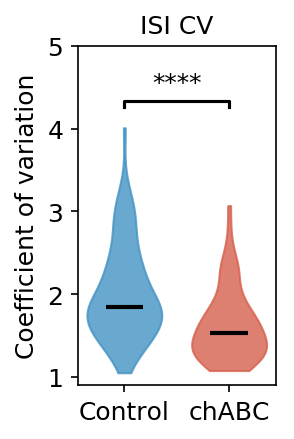

In [33]:
control = familiar.query('not chabc and interspike_interval_cv < 5')['interspike_interval_cv'].to_numpy()
chabc = familiar.query('chabc and interspike_interval_cv < 5')['interspike_interval_cv'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("ISI CV")
plt.ylabel("Coefficient of variation")
plt.ylim(0.9, 5)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "isi_cv.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "isi_cv.png", dpi=600, bbox_inches="tight")

U-test 3059.0 0.17927531771510485


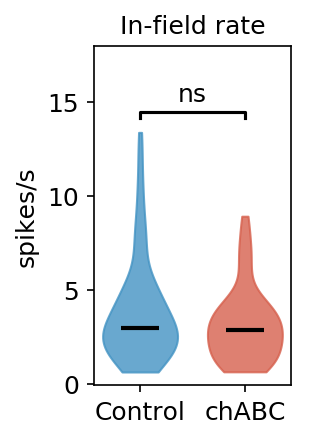

In [34]:
control = familiar.query('not chabc and in_field_mean_rate < 20')['in_field_mean_rate'].to_numpy()
chabc = familiar.query('chabc and in_field_mean_rate < 20')['in_field_mean_rate'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("In-field rate")
plt.ylabel("spikes/s")
plt.ylim(-0.1, 18)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "in_field_mean_rate.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "in_field_mean_rate.png", dpi=600, bbox_inches="tight")

U-test 2395.0 0.2283361389939801


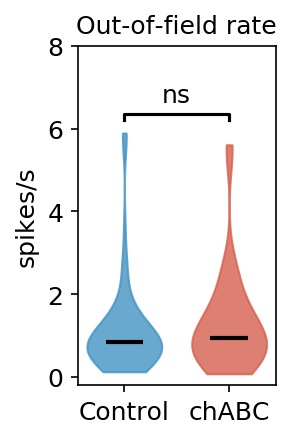

In [35]:
control = familiar.query('not chabc and average_rate < 10')['out_field_mean_rate'].to_numpy()
chabc = familiar.query('chabc and average_rate < 10')['out_field_mean_rate'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Out-of-field rate")
plt.ylabel("spikes/s")
plt.ylim(-0.2, 8)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "out_field_mean_rate.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "out_field_mean_rate.png", dpi=600, bbox_inches="tight")

U-test 4148.5 3.211257233354626e-08


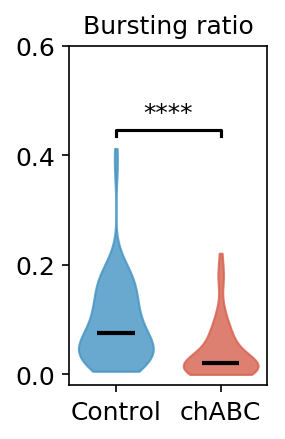

In [38]:
control = familiar.query('not chabc')['burst_event_ratio'].to_numpy()
chabc = familiar.query('chabc')['burst_event_ratio'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Bursting ratio")
plt.ylabel("")
plt.ylim(-0.02, 0.60)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "burst_event_ratio.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "burst_event_ratio.png", dpi=600, bbox_inches="tight")

U-test 3173.0 0.07490487246150968


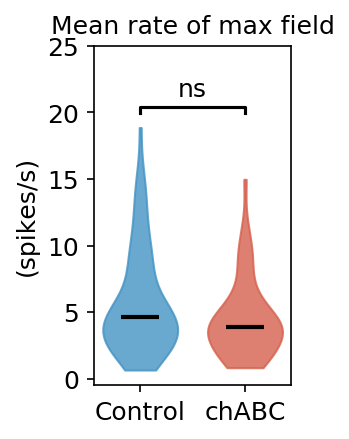

In [39]:
control = familiar.query('not chabc and average_rate < 10')['max_field_mean_rate'].to_numpy()
chabc = familiar.query('chabc and average_rate < 10')['max_field_mean_rate'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Mean rate of max field")
plt.ylabel("(spikes/s)")
plt.ylim(-0.5,25)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "max_field_mean_rate.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "max_field_mean_rate.png", dpi=600, bbox_inches="tight")

U-test 4142.0 3.7015760343321924e-08


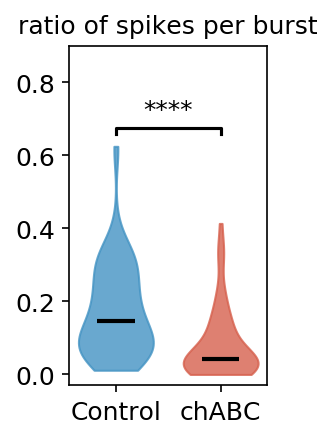

In [40]:
control = familiar.query('not chabc')['bursty_spike_ratio'].to_numpy()
chabc = familiar.query('chabc')['bursty_spike_ratio'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("ratio of spikes per burst")
plt.ylabel("")
plt.ylim(-0.03,0.9)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "bursty_spike_ratio.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "bursty_spike_ratio.png", dpi=600, bbox_inches="tight")

U-test 2812.0 0.6936793937070505


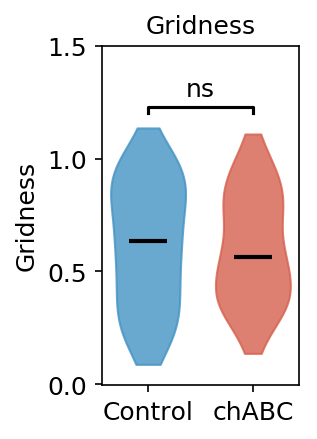

In [41]:
control = familiar.query('not chabc and average_rate < 10')['gridness'].to_numpy()
chabc = familiar.query('chabc and average_rate < 10')['gridness'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Gridness")
plt.ylabel("Gridness")
plt.ylim(-0.005, 1.5)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "gridness.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "gridness.png", dpi=600, bbox_inches="tight")

U-test 3307.0 0.021678445114939115


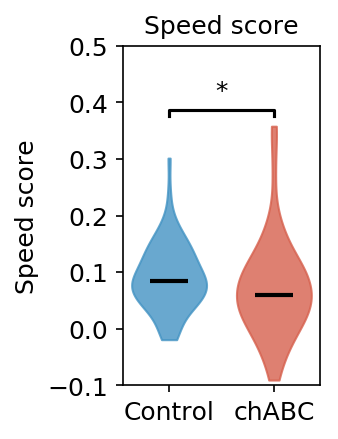

In [42]:
control = familiar.query('not chabc')['speed_score'].to_numpy()
chabc = familiar.query('chabc')['speed_score'].to_numpy()

plt.figure(figsize=(1.7, 3))
violinplot(control, chabc)
plt.title("Speed score")
plt.ylabel("Speed score")
plt.ylim(-0.1, 0.5)
plt.rcParams.update({'font.size': 12})

plt.savefig(output_path / "figures" / "speed_score.svg", bbox_inches="tight")
plt.savefig(output_path / "figures" / "speed_score.png", dpi=600, bbox_inches="tight")

# Register in Expipe

In [60]:
action = project.require_action("familiar_comparisons")

In [63]:
outdata = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in outdata.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        shutil.copytree(source, data_path)

In [67]:
pnnmec.registration.store_notebook(action, "20_spatial_correlation.ipynb")

In [69]:
action.modules["code_version"] = vc.create_code_version_module()
action.modules["data_version"] = vc.create_data_version_module(project_path)